This is my notebook file for playing around with new features, testing, etc.

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime
import numpy as np
import matplotlib.dates as mdates
import data_processing as dp
import data_viz as dv
pd.set_option("display.max_rows", None)
import definitions

In [6]:
dp.get_data()

LOG: Fetched all raw data
LOG: Filtered Data
LOG: Added HHS Provisional data
LOG: Done getting data


In [54]:
def plot_rt(data, region="USA", ax=None, plot_color="black", font={ 'size':13, 'weight':'light'}):
    ax = ax or plt.gca()
    x, y0 = data.date, data.iloc[:,1]
    ax.margins(y=.12)

    y1 = data.iloc[:,1].rolling(7).mean()
    ax.plot(x, y0, alpha=.3, color=plot_color)
    ax.plot(x, y1, color=plot_color)
    # Fills between 1 and plot
    ax.fill_between(x, y1, 1, where=(y1>1), color='red', alpha=0.2)
    ax.fill_between(x, y1, 1, where=(y1<1), color='green', alpha=0.2)
    
    # Get numbers for today and last week
    subtext = []
    for i in [-1,-8]:
        last_update_day = x.iloc[i].strftime('%b-%d')
        last_val = round(y0.iloc[i], 2)
        last_val_formatted = '{:,}'.format(last_val)
        subtext.append(f" {last_update_day}: {last_val_formatted}")
    ax.text(.5, 0.97, subtext[0], ha='center', transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.94, subtext[1], ha='center',transform=ax.transAxes, fontdict=font)
    
    # Find numbers for 7 day average and delta
    avg_formatted = round(y1.iloc[-1],2)
    avg_delta = y1.iloc[-1] - y1.iloc[-2]
    avg_delta_formatted = round(avg_delta,2)
    subtext.append(f" 7-day Average: {avg_formatted}")
    subtext.append(f" Change in 7-day Average from yesterday: {avg_delta_formatted}")
    # If region is US, calculate time to peak/trough
    if(region=="USA"):
        avg_delta_diff = 0
        for i in range(1,4):
            avg_delta_diff += y1.iloc[0-i] - y1.iloc[0-i-1]
        avg_delta_diff /= 3
        print(avg_delta_diff)
        time_to_peak = int(round((1 - y1.iloc[-1]) / avg_delta_diff)) 
        subtext.append(f" Days before peak/trough at current rate: {time_to_peak}")
        ax.text(.5, 0.85, subtext[4], ha='center',transform=ax.transAxes, fontdict=font)


    ax.text(.5, 0.91, subtext[2], ha='center',transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.88, subtext[3], ha='center',transform=ax.transAxes, fontdict=font)


    ax.grid(alpha=.4)
    ax.axhline(1, linestyle="--", color='black')
    return ax

In [59]:
def generate_rt(region="USA", regionString=False, start_date=pd.Timestamp(2021,1,1), end_date=pd.Timestamp.today()):
    if(not regionString):
        regionString = region
    label=f"{regionString} Weekly Growth in Hospitalizations"
    if(region == "USA"):
        data = dp.get_us_hospitalizations(start_date=start_date, end_date=end_date)
        data['pct_chg'] = 1 + data.iloc[:,1].pct_change(periods=7)
    else:
        if(isinstance(region, list)):
            data= dp.get_state_hospitalizations(state_codes=region, start_date=start_date, end_date=end_date)
            label=f"{region} Weekly Growth in Hospitalizations"
        else:
            data = dp.get_state_hospitalizations(state_codes=region, start_date=start_date, end_date=end_date)
        data['avg'] = data.iloc[:,1].rolling(7).mean()
        data['pct_chg'] = 1 + data.avg.pct_change(periods=7)
    
    fig,ax = plt.subplots(dpi=100, figsize=(13,10))
    plot_rt(data[['date', 'pct_chg']], region=region)
    fig.autofmt_xdate()
    fig.suptitle(label, fontsize=24)
    plt.show()

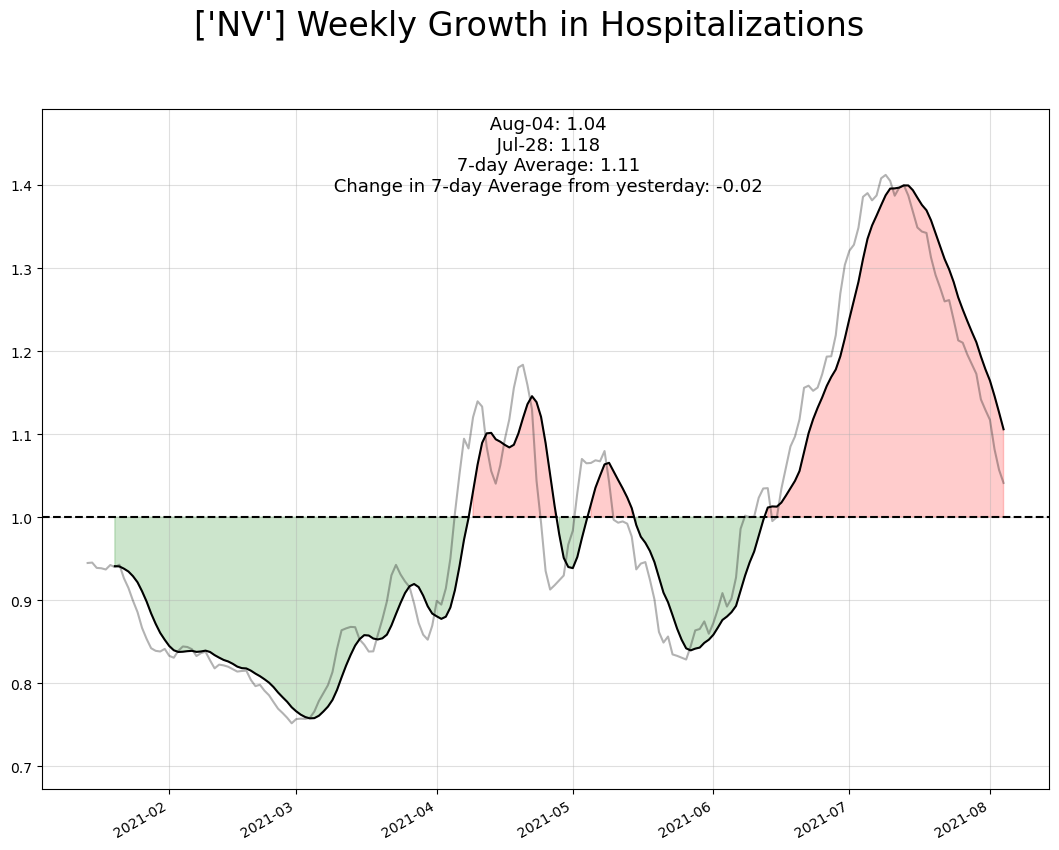

In [60]:
# Note to self -- smooth out regions, don't smooth out USA
generate_rt(region=["NV"])


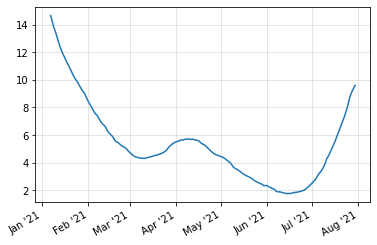

In [61]:
pos = dp.get_us_positivity(start_date=pd.Timestamp(2021,1,1), end_date=pd.Timestamp.today()-datetime.timedelta(4))
pos['day_avg'] = pos.iloc[:,1].rolling(7).mean()
pos['pct_chg'] = 1 + pos.day_avg.pct_change(periods=7)

fig, ax = plt.subplots()
ax.plot(pos.date, pos.day_avg)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
ax.grid(alpha=.4)
fig.autofmt_xdate()

In [155]:
pos = dp.get_us_positivity(start_date=pd.Timestamp(2021,7,1), end_date=pd.Timestamp.today()-datetime.timedelta())
pos['day_avg'] = pos.iloc[:,1].rolling(7).mean()
pos['pct_chg'] = 1 + pos.day_avg.pct_change(periods=7)
pos

,date,test_positivity,day_avg,pct_chg
0,2021-07-01,2.678242,NaN,NaN
1,2021-07-02,2.863025,NaN,NaN
2,2021-07-03,3.258219,NaN,NaN
3,2021-07-04,3.700851,NaN,NaN
4,2021-07-05,4.135691,NaN,NaN
5,2021-07-06,3.372060,NaN,NaN
6,2021-07-07,3.382404,3.341499,NaN
7,2021-07-08,3.868732,3.511569,NaN
8,2021-07-09,4.265961,3.711988,NaN
9,2021-07-10,4.869997,3.942243,NaN


In [82]:
cases[cases.date > pd.Timestamp(2021,7,23)]
#dp.hhs_data[dp.hhs_data.date > pd.Timestamp(2021,7,24)].sort_values("date", 0)
dp.hhs_data.date.max()

Timestamp('2021-08-02 00:00:00')

In [37]:
def plot_graphs(region="USA", start_date=pd.Timestamp(2020,3,1), end_date=pd.Timestamp.today()):
    if region == "USA":
        pos = dp.get_us_positivity(start_date, end_date)
        case = dp.get_us_cases(start_date, end_date)
        death = dp.get_us_deaths(start_date, end_date)
        hosp = dp.get_us_hospitalizations(start_date, end_date)
    else:
        pos = dp.get_state_positivity(definitions.regions[region], start_date, end_date)
        case = dp.get_state_cases(definitions.regions[region], start_date, end_date)
        death = dp.get_state_deaths(definitions.regions[region], start_date, end_date)
        hosp = dp.get_state_hospitalizations(definitions.regions[region], start_date, end_date)


    fig, axs = plt.subplots(2,2, figsize=(25,15))
    dv.plot(pos, axs[0,0], plot_color="purple", label=f"Test Positivity")
    dv.plot(case, axs[0,1], plot_color="red", label=f"Cases")
    dv.plot(hosp, axs[1,0], plot_color="blue", label=f"In Hospital")
    dv.plot(death, axs[1,1], plot_color="black", label=f"Deaths")

    fig.autofmt_xdate()
    fig.suptitle(f"{region} COVID Data {end_date.strftime('%m/%d/%y')}", fontweight="bold", fontsize=23)
    # plt.savefig(f"images/graphs/{region}.png", transparent=False, dpi=200, bbox_inches='tight', pad_inches=.1)
    print(f"LOG: Plotted graphs for {region}")

LOG: Plotted graphs for USA


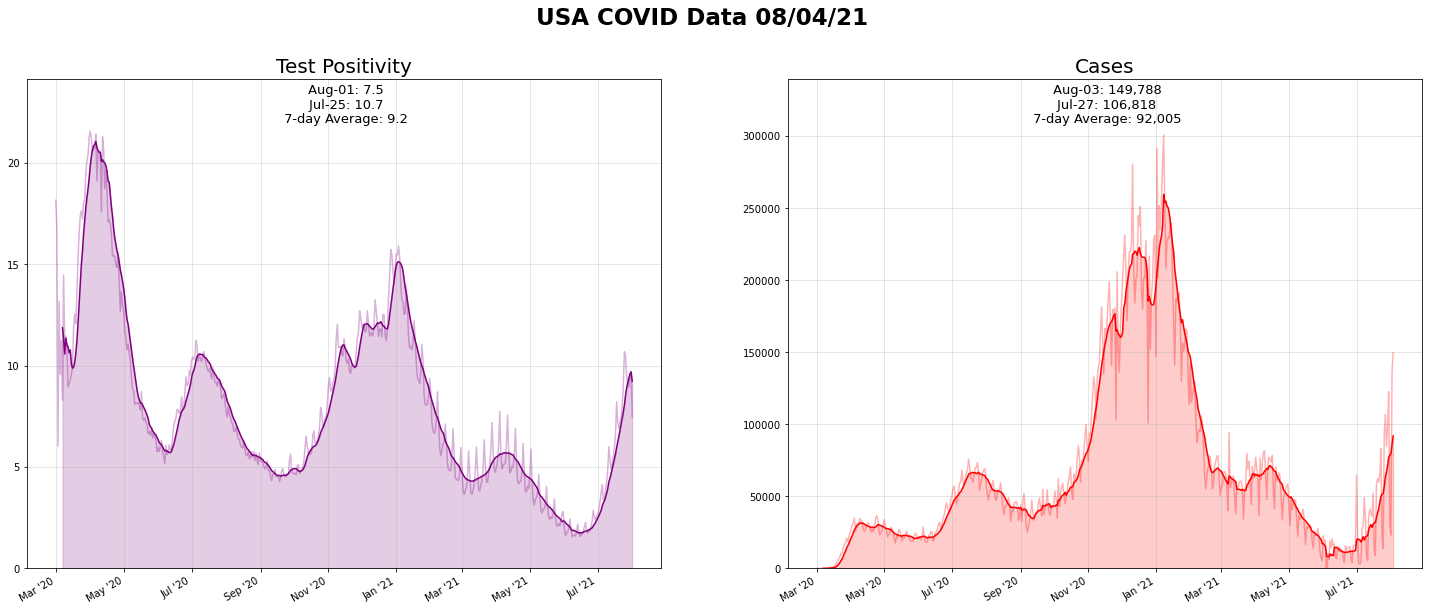

In [8]:
plot_graphs()

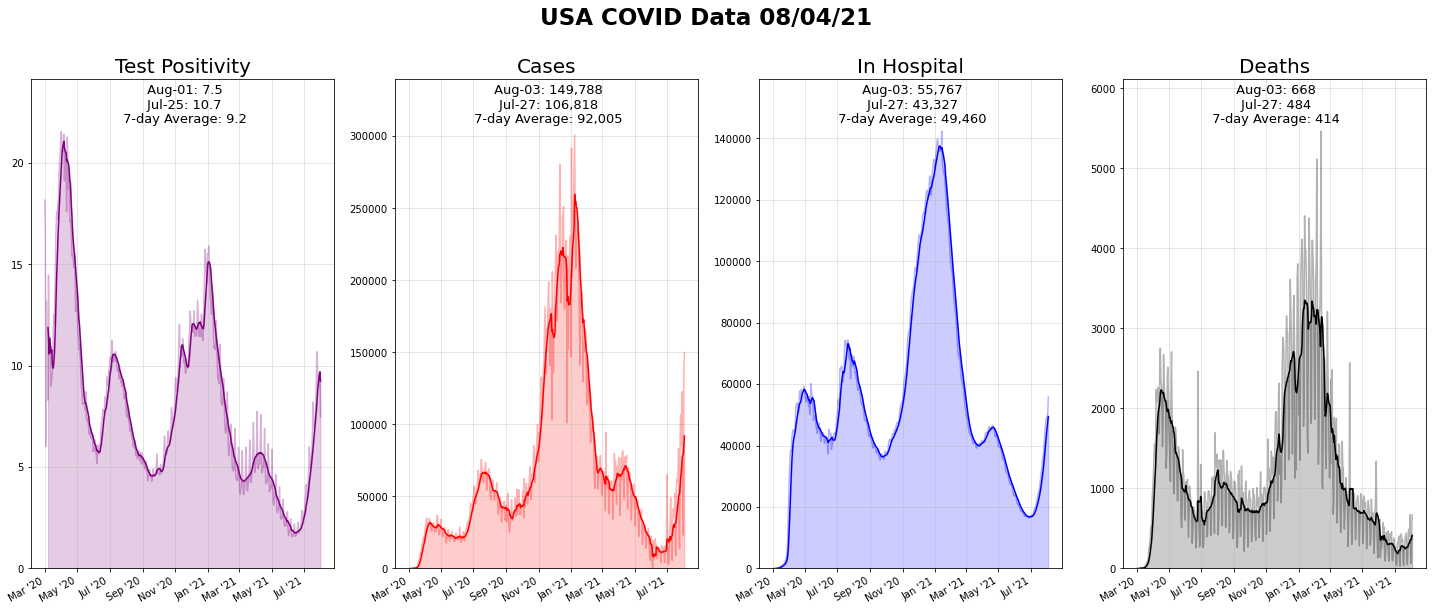

In [188]:
dv.plot_graphs()

In [18]:
import math